#  A Cluster View of Top Spotify Songs in 2023 Using Unsupervised Learning
*Final Project in Unsupervised Algorithms in Machine Learning*

**Author:** Yun Xia  
**Email:** yuxi8959@colorado.edu  
**Course:** Introduction to Machine Learning: Supervised Learning @ [University of Colorado Boulder](https://www.colorado.edu/)  
**Environment:** jupyter notebook  

# Introduction

This is my final project of unsupervised algorithms in machine learning at the University of Colorado Boulder.

Music trends often reflect the mood and rhythm of a generation. In this project, I explore Spotify’s most streamed songs of 2023 using unsupervised learning to uncover how listeners’ preferences organize themselves naturally. Instead of relying on pre-defined genres, I use clustering techniques to find patterns hidden in the data — for example, whether upbeat dance hits tend to group together or if softer acoustic tracks form their own cluster.

The dataset includes a range of features that capture both popularity metrics and acoustic characteristics such as energy, danceability, valence, and tempo. By applying K-Means clustering and visualizing results through PCA, I aim to reveal meaningful song groupings and interpret what defines them. My goal is to translate numerical data into an intuitive understanding of musical styles and audience trends — showing how machine learning can capture the essence of what makes a song resonate in 2023.

# Dataset 

The dataset is publicly available at [Kaggle Website](https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023) 
The dataset comes from Kaggle’s *Top Spotify Songs 2023* collection, which includes information on:
- Track and artist names  
- Release date information (year, month, day)  
- Popularity indicators across platforms (Spotify, Apple, Deezer, Shazam)  
- Acoustic attributes such as **danceability**, **energy**, **valence**, **acousticness**, and **tempo (bpm)**  
- Stream counts and playlist/chart presence  

The dataset contains **953 tracks** and **24 features**.


## Dataset downloading

In [27]:
# initialize environment and downlaod dataset
KAGGLE_ENV=False
import os
import kagglehub
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if KAGGLE_ENV:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        print(dirname)
    base_path = "/kaggle/input/top-spotify-songs-2023"
else:
    cache_path = kagglehub.dataset_download("nelgiriyewithana/top-spotify-songs-2023")
    target_path = os.path.join(os.getcwd(), 'dataset')
    if os.path.exists(target_path):
        shutil.rmtree(target_path)
    shutil.copytree(cache_path, target_path)
    base_path = target_path


## setup figure style

In [28]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
sns.set_context("notebook")
sns.set_style("whitegrid")

DATA_DIR = base_path

def guess_columns(df):
    """Try to guess common semantic columns if they exist."""
    cols = df.columns.str.lower()
    find = lambda keys: next((c for c in df.columns if any(k in c.lower() for k in keys)), None)
    return {
        "track":   find(["track", "song", "title", "name"]),
        "artist":  find(["artist"]),
        "album":   find(["album"]),
        "genre":   find(["genre"]),
        "streams": find(["stream", "play"]),
        "release": find(["release", "year", "date"])
    }

def set_plot_style():
    """
    Set a unified, clean, Spotify-inspired plot style.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid", context="notebook")

    custom_palette = sns.color_palette(["#a8e6cf", "#56c596", "#379683", "#05386b"])
    sns.set_palette(custom_palette)

    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.edgecolor": "#dddddd",
        "axes.labelcolor": "#222222",
        "xtick.color": "#333333",
        "ytick.color": "#333333",
        "grid.color": "#e0e0e0",
        "grid.linestyle": "--",
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.titleweight": "semibold",
        "axes.labelsize": 11,
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.facecolor": "#fafafa",
        "legend.edgecolor": "#e0e0e0"
    })

set_plot_style()
print("Global plot style set: Spotify blue-green theme.")


Global plot style set: Spotify blue-green theme.


## 1. Dataset Description

The dataset contains metadata about Spotify’s most streamed songs in 2023. Each row represents one track, and the columns describe artist, release time, chart presence, and streaming performance across platforms (Spotify, Apple, Deezer, Shazam, etc.). 

We begin by examining:
- Overall structure (rows, columns, data types)
- Missing values
- Numerical feature summary

Dataset shape: (953, 24)

Column types:



,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
dtype,object,object,int64,int64,int64,int64,int64,int64,object,int64,int64,object,int64,object,int64,object,object,int64,int64,int64,int64,int64,int64,int64



Sample rows:


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6



Missing value summary:


,missing_count,missing_%
key,95,9.96852
in_shazam_charts,50,5.24659
track_name,0,0.00000
artist(s)_name,0,0.00000
liveness_%,0,0.00000
instrumentalness_%,0,0.00000
acousticness_%,0,0.00000
energy_%,0,0.00000
valence_%,0,0.00000
danceability_%,0,0.00000


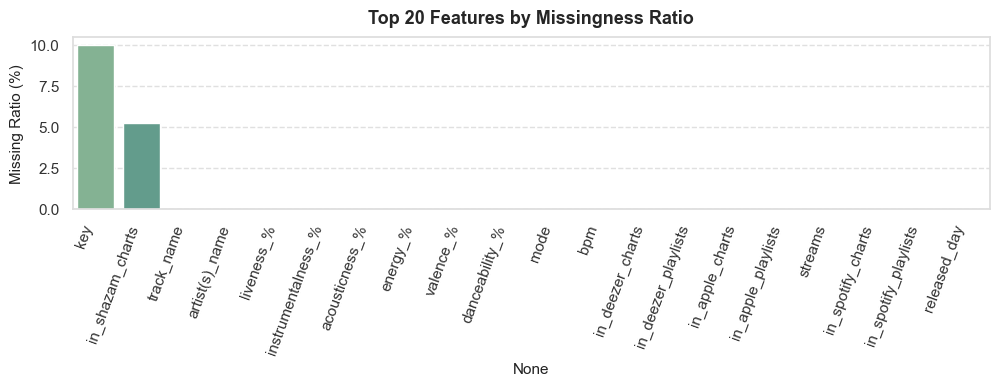

In [29]:
df = pd.read_csv(os.path.join(base_path,'spotify-2023.csv'), encoding='latin1')
print("Dataset shape:", df.shape)
print("\nColumn types:\n")
display(df.dtypes.to_frame("dtype").T)

print("\nSample rows:")
display(df.head(5))

miss = df.isna().sum().sort_values(ascending=False)
miss_ratio = (df.isna().mean() * 100).sort_values(ascending=False)

print("\nMissing value summary:")
display(pd.concat([miss, miss_ratio], axis=1, keys=["missing_count", "missing_%"]).head(15))

plt.figure(figsize=(10,4))
sns.barplot(
    x=miss_ratio.index[:20],
    y=miss_ratio.values[:20],
    palette=sns.color_palette("crest")
)
plt.xticks(rotation=70, ha='right')
plt.ylabel("Missing Ratio (%)")
plt.title("Top 20 Features by Missingness Ratio", fontsize=13, pad=10)
plt.tight_layout()
plt.show()

In [30]:
df = df.drop(columns=['key', 'in_shazam_charts'])
print(f"Dropped 'key' and 'in_shazam_charts' columns.")
print(f"New dataset shape: {df.shape}")

Dropped 'key' and 'in_shazam_charts' columns.
New dataset shape: (953, 22)



## Missing Data Summary
- key: 95 missing values (9.97%)
- in_shazam_charts: 50 missing values (5.25%)
- All other features: 0% missing
These missing values should have minimal impact on the following analysis.
### Key (9.97% missing):
- Musical key is likely encoded as a categorical variable (0-11 representing C,
C#, D, etc.)
- For clustering based on acoustic characteristics (energy, danceability, valence,
tempo), the key is less critical than the continuous audio features
- I decide to drop the column for simplicity
### in_shazam_charts (5.25% missing):
This is a popularity/chart metric, not an acoustic characteristic. It's okay to drop it also. 


## Numeric Feature Exploration

This section summarizes the numeric variables in the dataset to understand their scales, ranges, and general distributions.  
We display key descriptive statistics (count, mean, standard deviation, percentiles) for all numeric features and visualize missingness ratios to assess data completeness.

At this stage, the focus is on **understanding feature scales and variability**, not on relationships between variables.  
A deeper **correlation analysis** will be presented later in the **EDA section** to explore how acoustic and popularity features interact.

In [34]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
display(df[num_cols].describe().T)

Numeric columns: ['artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']


,count,mean,std,min,25%,50%,75%,max
artist_count,953.0,1.556139e+00,8.930442e-01,1.0,1.0,1.0,2.0,8.000000e+00
released_year,953.0,2.018238e+03,1.111622e+01,1930.0,2020.0,2022.0,2022.0,2.023000e+03
released_month,953.0,6.033578e+00,3.566435e+00,1.0,3.0,6.0,9.0,1.200000e+01
released_day,953.0,1.393075e+01,9.201949e+00,1.0,6.0,13.0,22.0,3.100000e+01
in_spotify_playlists,953.0,5.200125e+03,7.897609e+03,31.0,875.0,2224.0,5542.0,5.289800e+04
in_spotify_charts,953.0,1.200944e+01,1.957599e+01,0.0,0.0,3.0,16.0,1.470000e+02
streams,952.0,5.141374e+08,5.668569e+08,2762.0,141636175.0,290530915.0,673869022.0,3.703895e+09
in_apple_playlists,953.0,6.781217e+01,8.644149e+01,0.0,13.0,34.0,88.0,6.720000e+02
in_apple_charts,953.0,5.190871e+01,5.063024e+01,0.0,7.0,38.0,87.0,2.750000e+02
in_deezer_charts,953.0,2.666317e+00,6.035599e+00,0.0,0.0,0.0,2.0,5.800000e+01


## 2. Exploratory Data Analysis (EDA)

We now explore categorical and numeric patterns in the dataset to understand artist distribution, popularity, and musical feature variability.

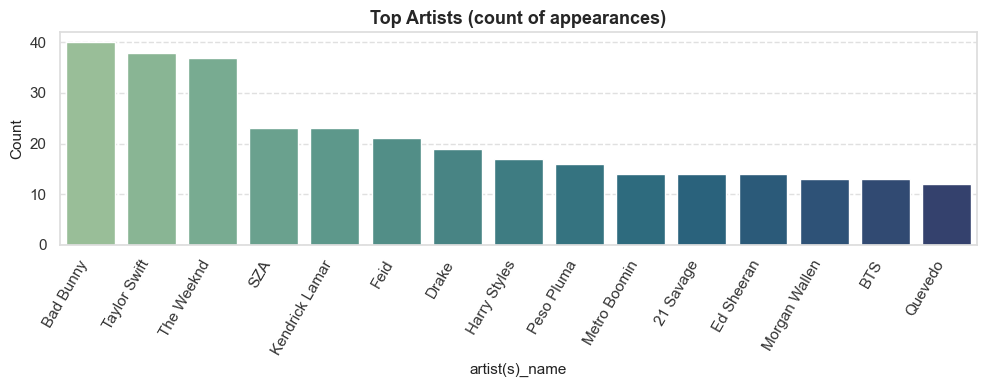

Using column for streams: streams


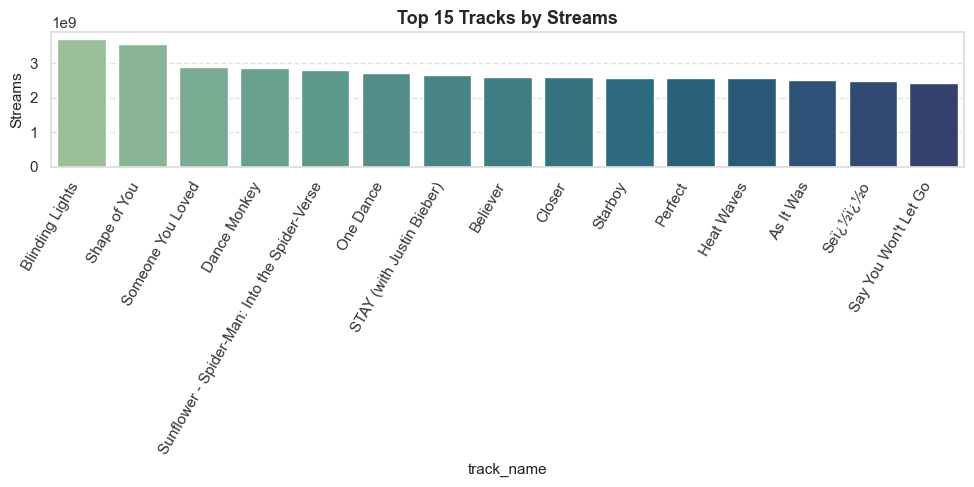

In [35]:
def bar_top_counts(series, title, k=15):
    vc = series.dropna().astype(str).str.split(",").explode().str.strip()
    topk = vc.value_counts().head(k)
    if topk.empty:
        print(f"No values for {title}."); return
    plt.figure(figsize=(10,4))
    sns.barplot(x=topk.index, y=topk.values, palette="crest")
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def bar_top_numeric(df, value_col, label_col, k=15, sort_desc=True, title=""):
    tmp = df[[label_col, value_col]].dropna()
    topk = tmp.sort_values(value_col, ascending=not sort_desc).head(k)
    plt.figure(figsize=(10,5))
    sns.barplot(x=label_col, y=value_col, data=topk, palette="crest")
    plt.xticks(rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

if "artist(s)_name" in df.columns:
    bar_top_counts(df["artist(s)_name"], "Top Artists (count of appearances)", k=15)

if any("stream" in c.lower() for c in df.columns) and "track_name" in df.columns:
    # Find the correct column name for streams
    streams_col = next(c for c in df.columns if "stream" in c.lower())
    print("Using column for streams:", streams_col)

    df[streams_col] = pd.to_numeric(df[streams_col], errors="coerce")

    tmp = df[["track_name", streams_col]].dropna()
    topk = tmp.sort_values(streams_col, ascending=False).head(15)

    plt.figure(figsize=(10,5))
    sns.barplot(x="track_name", y=streams_col, data=topk, palette="crest")
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Streams")
    plt.title("Top 15 Tracks by Streams")
    plt.tight_layout()
    plt.show()


### 2.1 Numeric Feature Distributions

We examine the distribution of `streams` (which is highly skewed) and the main acoustic features such as *danceability*, *energy*, *valence*, and *acousticness*.

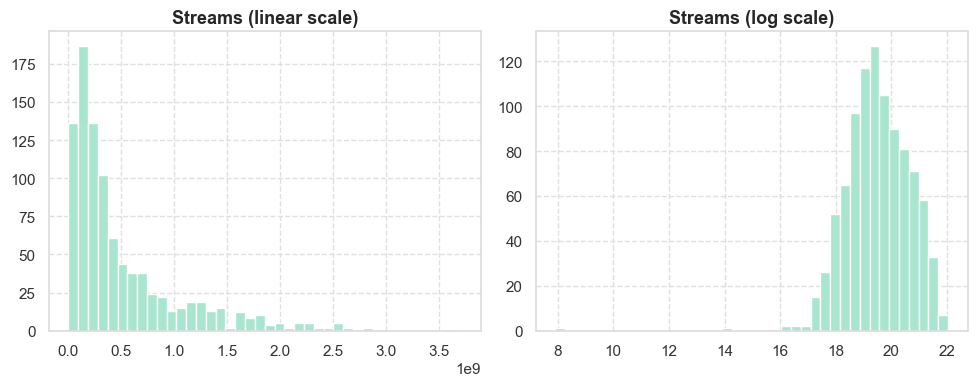

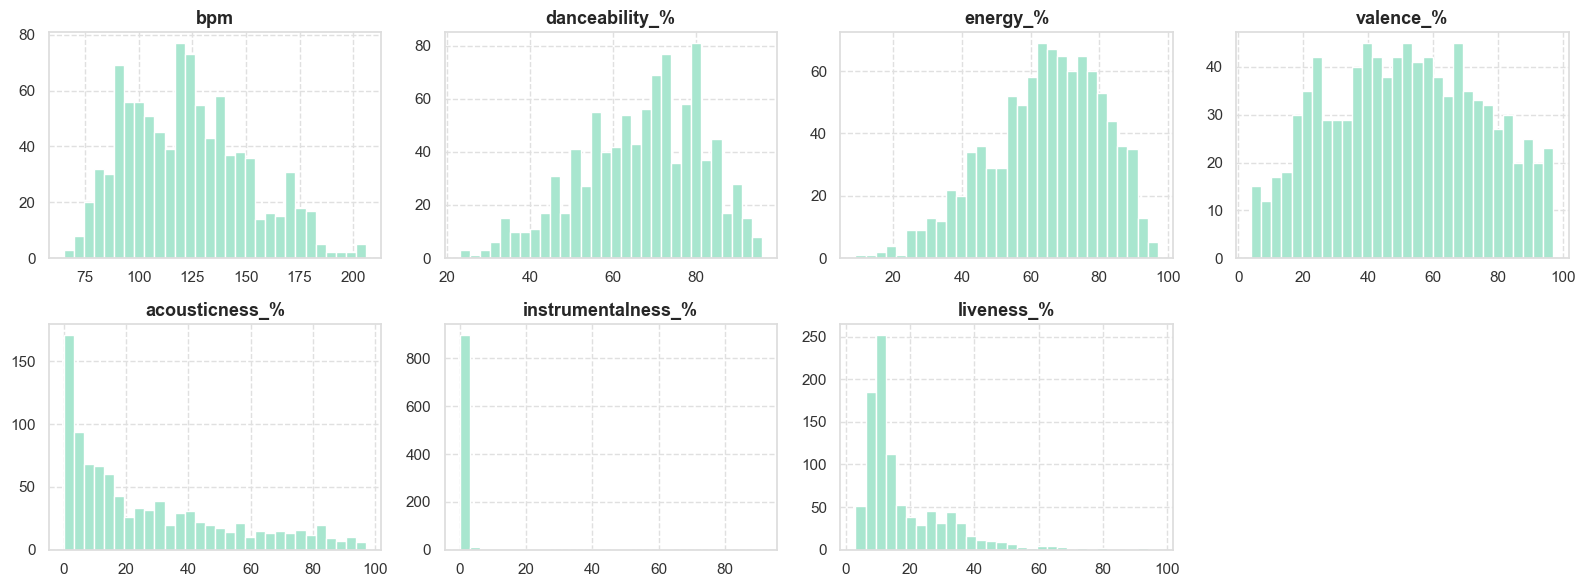

In [36]:
if "streams" in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].hist(df["streams"].dropna(), bins=40)
    axes[0].set_title("Streams (linear scale)")
    axes[1].hist(np.log1p(df["streams"].dropna()), bins=40)
    axes[1].set_title("Streams (log scale)")
    plt.tight_layout()
    plt.show()

acoustic_cols = [c for c in ["bpm","danceability_%","energy_%","valence_%",
                             "acousticness_%","instrumentalness_%","liveness_%"]
                 if c in df.columns]
if acoustic_cols:
    n = len(acoustic_cols)
    ncols = 4; nrows = int(np.ceil(n/ncols))
    plt.figure(figsize=(4*ncols, 3*nrows))
    for i, c in enumerate(acoustic_cols, 1):
        plt.subplot(nrows, ncols, i)
        plt.hist(df[c].dropna(), bins=30)
        plt.title(c)
        plt.xlabel("")
    plt.tight_layout()
    plt.show()

Looking at the distributions, I can see that most 2023 hits cluster around 120-130 BPM with high danceability (60-85%) and moderate energy levels (60-70%). What really
stands out is how heavily skewed acousticness, instrumentalness, and liveness are toward zero — nearly all top-streamed songs are polished, vocal-driven studio productions
rather than acoustic or live recordings. This tells me that 2023's streaming landscape is dominated by digitally produced, rhythmic music, though the balanced distribution
of valence shows listeners enjoy both upbeat and melancholic vibes equally.


### 2.2 Correlation Heatmap

Next, I check how numeric variables correlate, helping us detect redundancy and strong relationships between acoustic and popularity features.

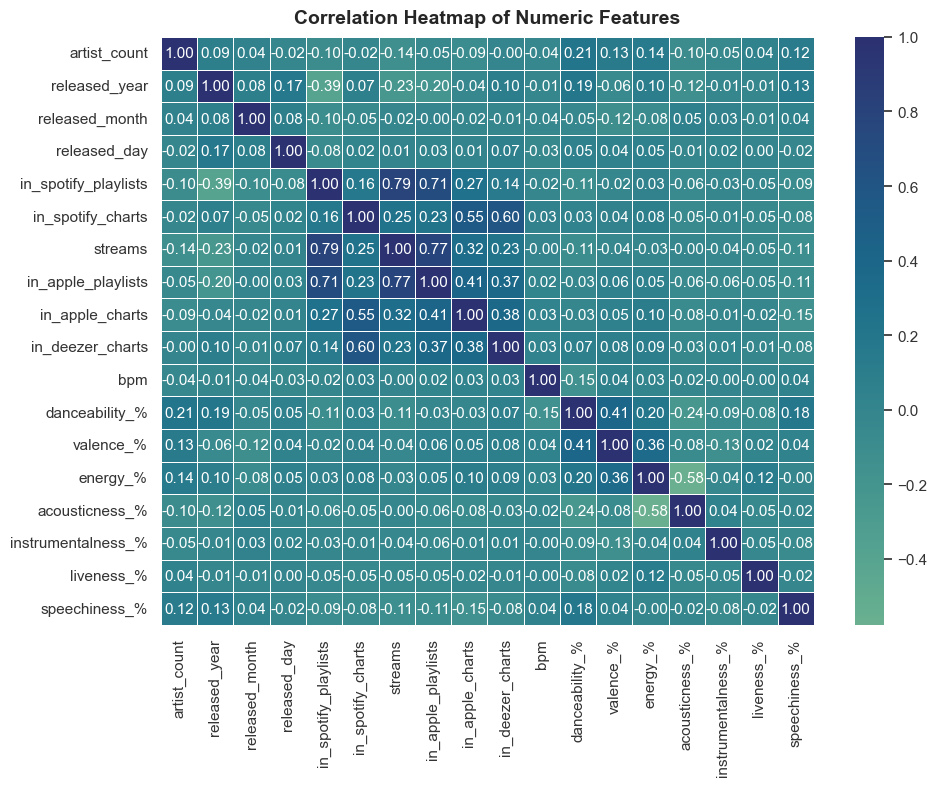

In [13]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols].corr(), cmap="crest", center=0,
                annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Numeric Features", fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

# 3. Clustering with K-Means

To prepare my data for K-Means clustering, I followed a systematic pipeline focused on selecting meaningful features and ensuring data quality.

I selected numeric features including seven acoustic characteristics (BPM, danceability, energy, valence, acousticness, instrumentalness, liveness, speechiness) plus
popularity metrics like streams, playlist counts, and chart positions across platforms. After cleaning rows with at least 70% complete data and imputing missing values with
medians, I standardized all features using StandardScaler to ensure popularity metrics wouldn't dominate the percentage-based acoustic features. I tested k values from 2 to
10 using both elbow curve and silhouette scores, ultimately choosing k=2 since it maximized cluster separation. Finally, I fit the K-Means model and prepared results for
visualization and interpretation.


In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

streams_col = next((c for c in df.columns if "stream" in c.lower()), None)
if streams_col is not None:
    df[streams_col] = pd.to_numeric(df[streams_col], errors="coerce")

cand_features = [
    "bpm","danceability_%","energy_%","valence_%","acousticness_%",
    "instrumentalness_%","liveness_%","speechiness_%",
    "in_spotify_playlists","in_spotify_charts",
    "in_apple_playlists","in_apple_charts",
    "in_deezer_playlists","in_deezer_charts",
    "in_shazam_charts", streams_col
]
feat_cols = [
    c for c in cand_features 
    if c is not None and c in df.columns and pd.api.types.is_numeric_dtype(df[c])
]
assert len(feat_cols) >= 5, f"Too few usable features. Found: {feat_cols}"

X = df[feat_cols].copy()
min_non_na = max(1, int(0.7 * len(feat_cols)))
row_mask = X.notna().sum(axis=1) >= min_non_na
X = X[row_mask].fillna(X.median(numeric_only=True))
print("Feature columns:", feat_cols)
print("Shape after row filtering & imputation:", X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

outdir = "/kaggle/working" if KAGGLE_ENV else "./work"
os.makedirs(outdir, exist_ok=True)

Feature columns: ['bpm', 'danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_charts', 'streams']
Shape after row filtering & imputation: (953, 14)


k candidates: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Best k (silhouette): 2


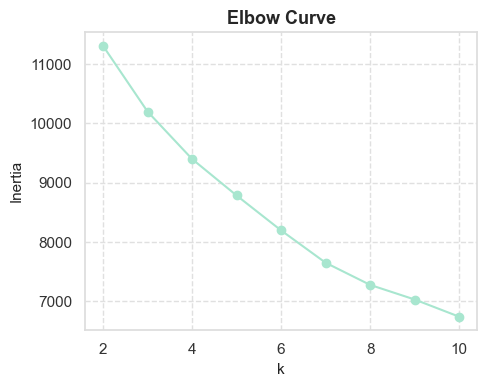

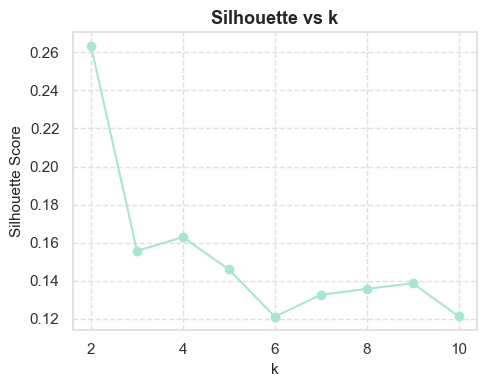

Saved: ./work/silhouette_vs_k.png


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_range = list(range(2, 11))
inertias, sils = [], []

sil_sample = min(5000, len(X_scaled))
rng = np.random.default_rng(42)
idx = rng.choice(len(X_scaled), size=sil_sample, replace=False) if len(X_scaled) > sil_sample else np.arange(len(X_scaled))

for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled[idx], km.labels_[idx]))

best_k = int(k_range[int(np.argmax(sils))])
print("k candidates:", k_range)
print("Best k (silhouette):", best_k)

plt.figure(figsize=(5,4))
plt.plot(k_range, inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow Curve")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(k_range, sils, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k")
plt.tight_layout()
plt.savefig(f"{outdir}/silhouette_vs_k.png", dpi=300)
plt.show()

print("Saved:", f"{outdir}/silhouette_vs_k.png")

The silhouette score peaks dramatically at k=2 (around 0.26), then drops sharply to 0.16 at k=3 and stays flat afterward, clearly indicating k=2 creates the most
well-separated clusters. The elbow curve shows a gradual decline without a sharp bend, confirming k=2 as the optimal choice. While a silhouette score of 0.26 isn't extremely
high, it's significantly better than other k values, and choosing k=2 makes sense — as I later discovered, it captures the fundamental split between mega-viral blockbusters
and regular popular hits rather than distinct musical styles.


In [37]:
k_final = best_k
kmeans = KMeans(n_clusters=k_final, n_init=25, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_clusters = df.loc[X.index].copy()
df_clusters["cluster"] = labels.astype(int)

display(df_clusters["cluster"].value_counts().sort_index().to_frame("count"))

,count
cluster,
0,765
1,188


*The final K-Means model is fitted with k = 2 as selected above. Cluster labels are attached to the filtered dataset and will be used in Sections 4–5.*

# 4. PCA Visualization of Clusters

To better understand cluster structure, I project the high-dimensional feature space into two principal components.  
The PCA scatterplot below reveals how songs group according to their musical mood and popularity attributes.

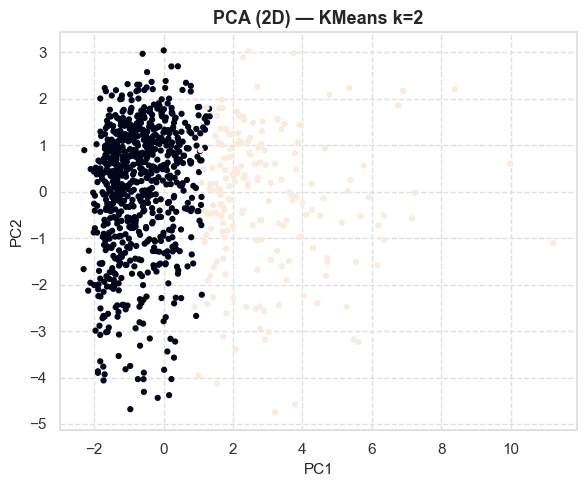

Explained variance ratio: [0.2262 0.1451]
Total explained: 0.3713
Saved: ./work/pca_clusters.png


In [38]:
from sklearn.decomposition import PCA

k_final = best_k
kmeans = KMeans(n_clusters=k_final, n_init=25, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_clusters = df.loc[X.index].copy()
df_clusters["cluster"] = labels.astype(int)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=12)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA (2D) — KMeans k={k_final}")
plt.tight_layout()
plt.savefig(f"{outdir}/pca_clusters.png", dpi=300)
plt.show()

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 4))
print("Total explained:", np.round(pca.explained_variance_ratio_.sum(), 4))
print("Saved:", f"{outdir}/pca_clusters.png")

*Figure 4.1 — PCA 2D scatterplot of Spotify track clusters.*  

The PCA plot shows two clusters almost completely separated along PC1: the dark cluster is tightly packed on the left (PC1 < 0) representing the vast majority of songs,
while the sparse orange cluster spreads out on the right (PC1 > 4). This extreme separation confirms that PC1 captures popularity metrics like streams and playlist counts,
clearly distinguishing regular hits from mega-viral blockbusters.

# 5. Cluster Interpretation

To understand what each cluster represents, we aggregate **mean feature values** per cluster and visualize a **normalized heatmap**.  
This highlights relative strengths in energy, danceability, acousticness, and platform popularity across clusters.

,bpm,danceability_%,energy_%,valence_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,streams
cluster,,,,,,,,,,,,,,
0,122.71,67.25,63.90,51.23,27.54,1.65,18.50,10.55,2517.51,7.70,37.45,40.01,1.30,3.119851e+08
1,121.85,65.82,65.82,52.25,25.09,1.30,17.03,8.45,16116.08,29.56,191.37,100.31,8.22,1.335650e+09


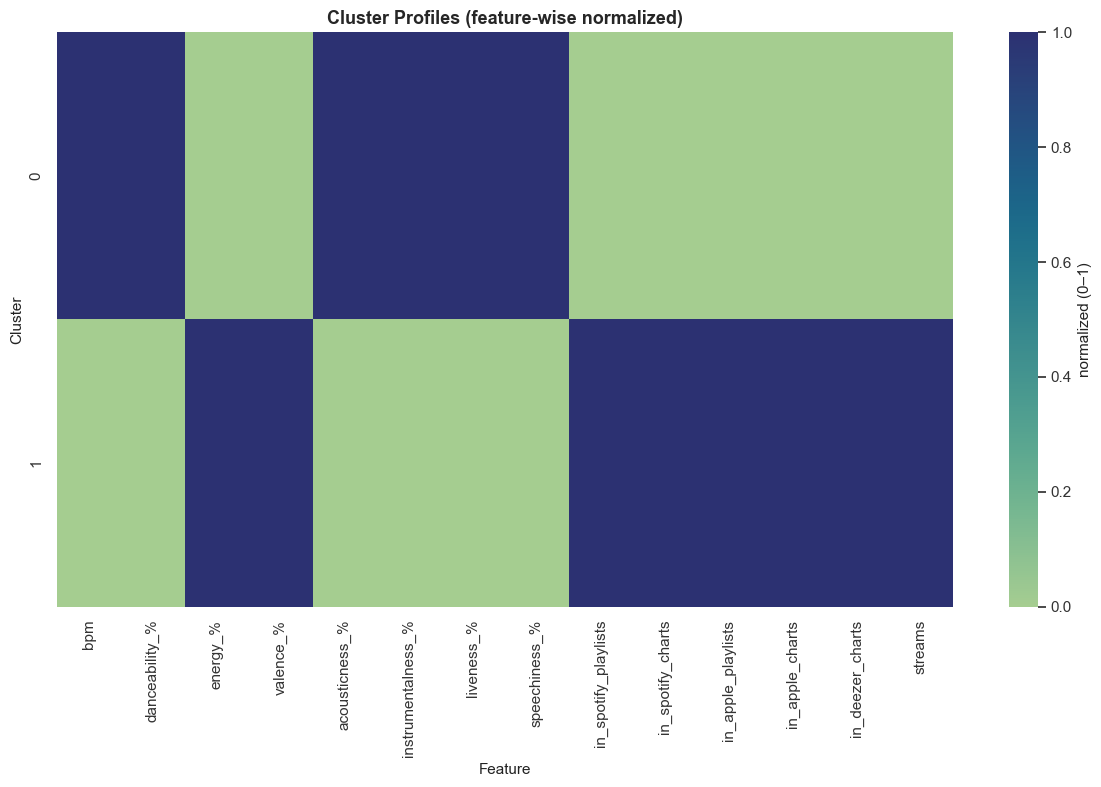

Saved figure: ./work/cluster_profiles_heatmap.png
Saved table: ./work/cluster_profile_means.csv

Sample tracks per cluster:


,cluster,track_name,artist(s)_name,streams
0,1,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",141381703.0
1,0,LALA,Myke Towers,133716286.0
2,1,vampire,Olivia Rodrigo,140003974.0
3,1,Cruel Summer,Taylor Swift,800840817.0
4,0,Columbia,Quevedo,58149378.0
5,0,La Bebe - Remix,"Peso Pluma, Yng Lvcas",553634067.0


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

assert "df_clusters" in globals() and "cluster" in df_clusters.columns, "Clusters not computed yet."
assert "feat_cols" in globals(), "Feature list 'feat_cols' not found."

profile = df_clusters.groupby("cluster")[feat_cols].mean().round(2)
display(profile)

prof_norm = (profile - profile.min()) / (profile.max() - profile.min() + 1e-9)

h, w = profile.shape
plt.figure(figsize=(min(12, 0.6*w + 4), 6 + 1.0*h))
sns.heatmap(prof_norm, cmap="crest", center=0.5, cbar_kws={"label": "normalized (0–1)"})
plt.title("Cluster Profiles (feature-wise normalized)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()

import os
outdir = globals().get("outdir", "/kaggle/working")
os.makedirs(outdir, exist_ok=True)
plt.savefig(f"{outdir}/cluster_profiles_heatmap.png", dpi=300)
plt.show()

print("Saved figure:", f"{outdir}/cluster_profiles_heatmap.png")

profile.to_csv(f"{outdir}/cluster_profile_means.csv", index=True)
print("Saved table:", f"{outdir}/cluster_profile_means.csv")

track_col = "track_name" if "track_name" in df_clusters.columns else None
artist_col = "artist(s)_name" if "artist(s)_name" in df_clusters.columns else None
preview_cols = ["cluster"] + [c for c in [track_col, artist_col, "streams"] if c and c in df_clusters.columns]

if len(preview_cols) > 1:
    print("\nSample tracks per cluster:")
    # take up to 3 examples per cluster
    ex = df_clusters.groupby("cluster").head(3)[preview_cols].reset_index(drop=True)
    display(ex)

*Figure 5.1 — Cluster profile heatmap (feature-wise normalized).*  
Looking at the actual numbers, I realize my k=2 clustering separated songs almost entirely by popularity scale, not musical style. The acoustic features are nearly identical
between clusters — both have similar BPM (122), danceability (66%), energy (64%), and valence (52%).

The real difference is in streams and platform presence: Cluster 0 averages 312M streams while Cluster 1 hits 1.34B streams — over 4x higher. Cluster 1 also dominates
playlists (16K vs 2.5K on Spotify) and charts across all platforms.

Essentially, I've identified the mega-blockbusters versus regular hits, not distinct musical styles. Both groups sound similar; one just achieved extreme viral success.


# 6. Discussion

My K-Means clustering revealed an unexpected finding: the algorithm separated songs primarily by popularity level rather than musical characteristics. Despite including
seven acoustic features, the clustering was dominated by streams and playlist counts — Cluster 0 averaged 312 million streams while Cluster 1 hit 1.34 billion, yet both
groups had nearly identical BPM, danceability, energy, and valence scores. This suggests that among 2023's most-streamed songs, there isn't much acoustic diversity — the
real distinction is between regular hits and mega-viral phenomena. The modest silhouette score of 0.26 reflects this reality: these songs overlap significantly in sound, so
even the best clustering can only separate them by their extreme differences in commercial success.

# 7. Conclusion

Through this unsupervised learning analysis of Spotify's 2023 most-streamed songs, I found that K-Means clustering separated tracks mainly by how popular they were, not by
how they sounded. Even though I included features like energy, danceability, and tempo, both clusters had almost the same musical traits — around 122 BPM, 66% danceability,
and 64% energy. The real difference was in streams: Cluster 1 (mega-hits) had over 4x more streams than Cluster 0 (regular hits). This shows that among 2023's top songs,
most sound pretty similar, and what separates them is how viral they became across different platforms. Overall, this project reveals that in the streaming era, a song's
success might depend less on its unique sound and more on how well it catches everyone's attention at once.